In [1]:
# Parameters
variable = "temp"
model_name = "AWICM-3"
model_path = "/work/ab0995/a270275/experiments/awicm3test011/outdata"
reference_path = "/work/ab0246/a270092/postprocessing/climatologies/fdiag/"
reference_years = "1985"
model_start = 1990
model_end = 1991
remap_resolution = "180x91"
mesh_file = "mesh.nc"
meshpath = "/work/ab0246/a270092/input/fesom2/core2/"
out_path = './output'
save_path='/work/ab0995/a270275/runconfig/Results/AWICM3_test031'
tripyrun_name='AWICM3_test031'
dpi = 150
tripyview_path="/home/a/a270275/tripyview"

In [2]:
# Add the parent directory to sys.path and load config
import sys
import os
import pdb
print("tripypath",tripyview_path)
sys.path.append(tripyview_path)
from config import *

# Mark as started
SCRIPT_NAME = "part11_zonal_plots.ipynb"   #ADAPT
update_status(SCRIPT_NAME, " Started")


tripypath /home/a/a270275/tripyview


/home/a/a270275/.conda/envs/reval/lib/python3.12/site-packages/pyfesom2/climatology.py:14: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.
/work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2


/work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ab0246/a270092/input/fesom2/core2/pickle_mesh_py3_fesom2


100%|██████████| 2/2 [00:00<00:00, 2478.90it/s]


[########################################] | 100% Completed | 2.11 ss
Shape: (2, 12, 180, 360)
NaNs gesamt: 1243631
(2, 12, 180, 360)


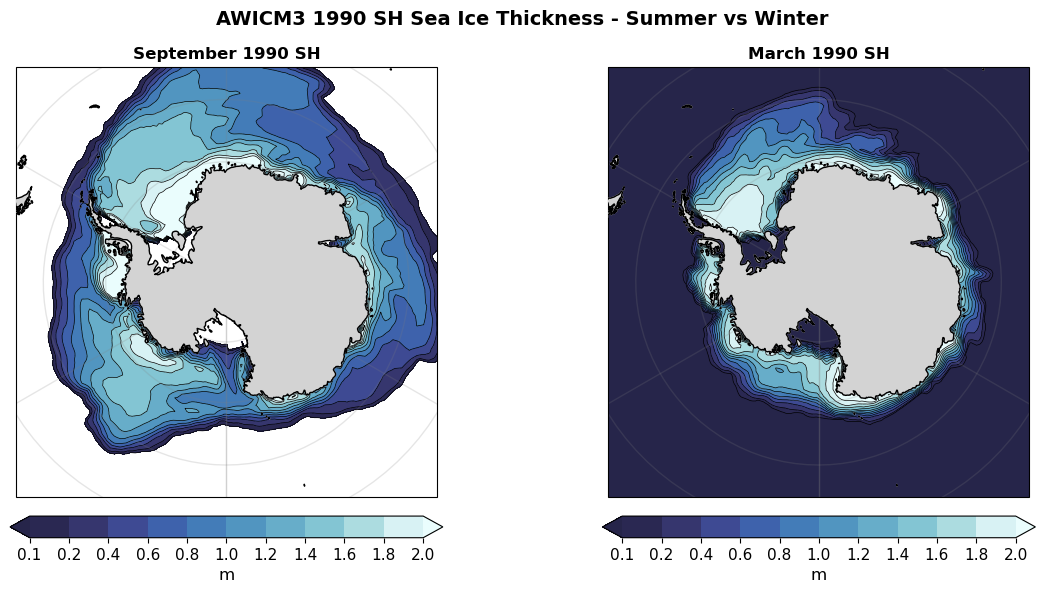

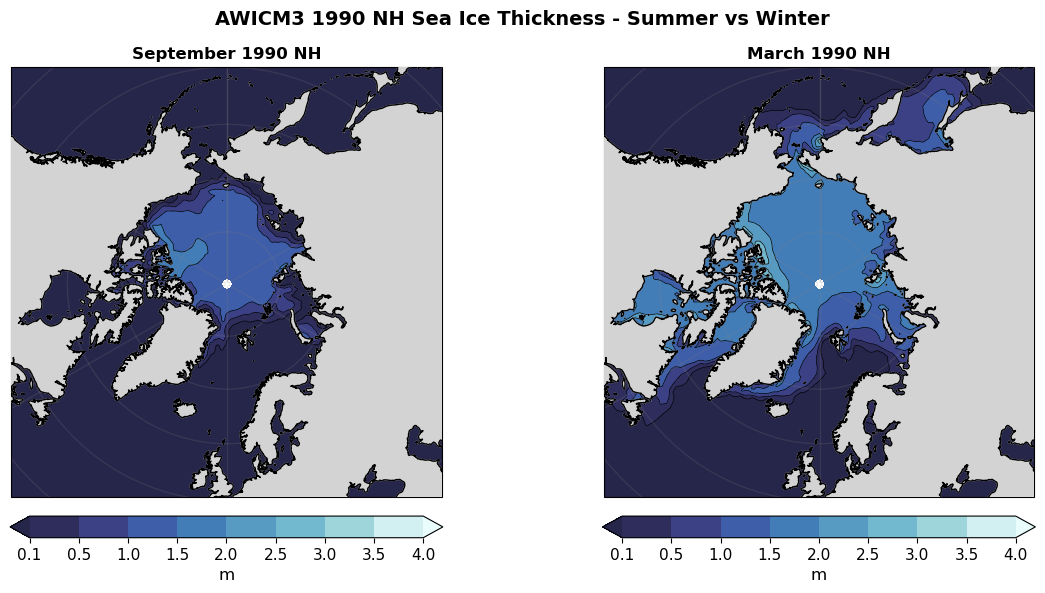

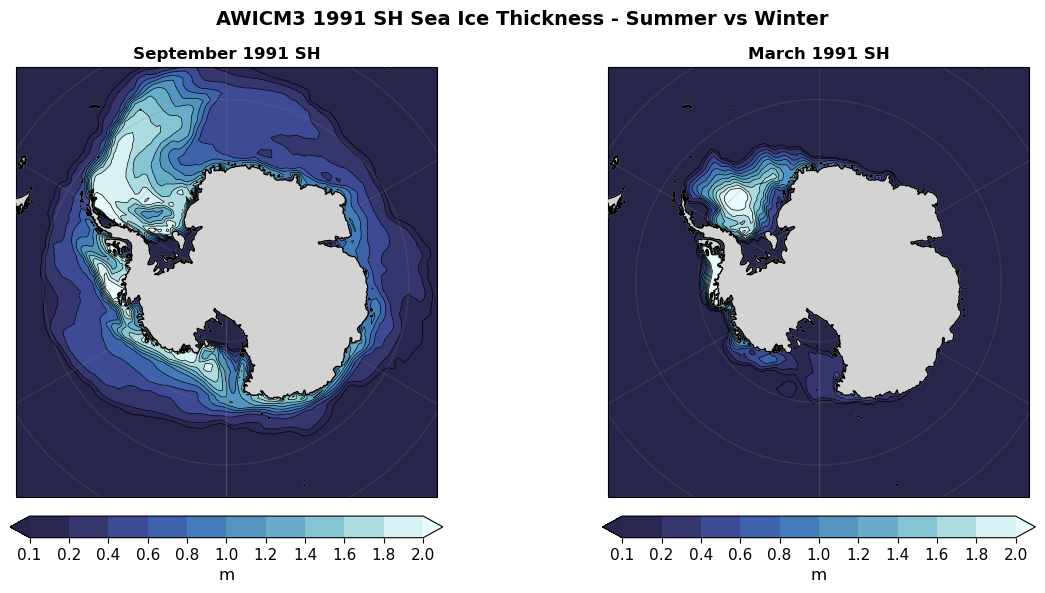

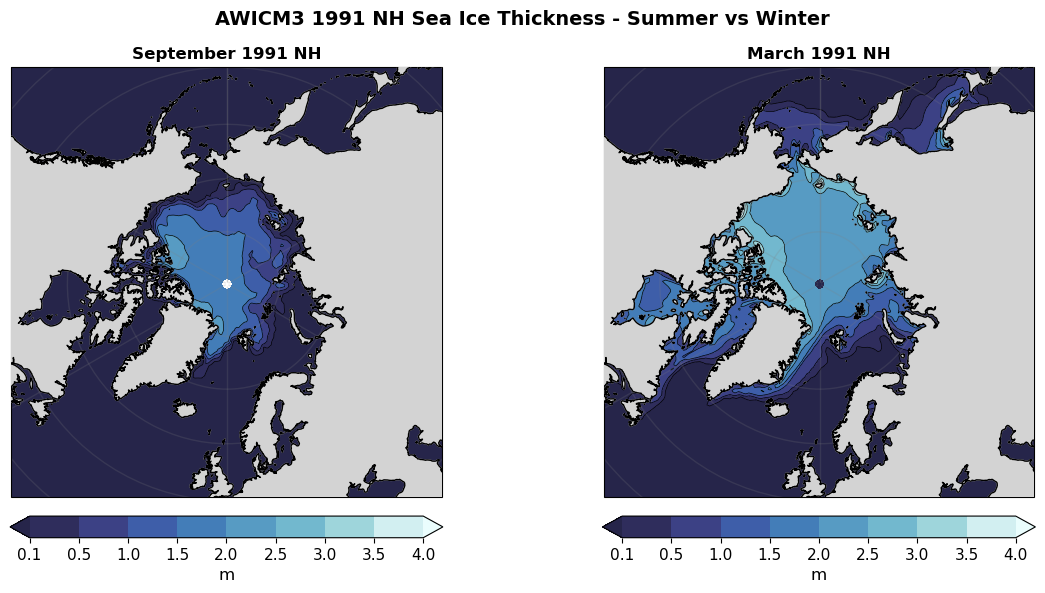

In [3]:
figsize=(6,4.5)
remap_resolution= '360x180'
out_path = save_path +  "/figures"

# # Sea ice thickness

# In[16]:


variable = 'm_ice'
input_paths = model_path
input_names = model_name

years = range(model_start, model_end+1)
res=[180,180]
figsize=(6,6)
levels = [0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
units = r'$^\circ$C'
columns = 2
dpi = 300
ofile = variable
region = "Global Ocean"

# Obtain input names from path if not set explicitly
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

# Load fesom2 mesh
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

# Load model Data
data = OrderedDict()

def load_parallel(variable,path,remap_resolution,meshpath,mesh_file):
    data1 = cdo.copy(input='-setmissval,nan -setctomiss,0 -remap,r'+remap_resolution+','+meshpath+'/weights_unstr_2_r'+remap_resolution+'.nc -setgrid,'+meshpath+'/'+mesh_file+' '+str(path),returnArray=variable)
    np.shape(data1)
    return data1




    
datat = []
t = []
temporary = []
for year in tqdm(years):
    path = input_paths+'/fesom/'+variable+'.fesom.'+str(year)+'.nc'
        
    temporary = dask.delayed(load_parallel)(variable,path,remap_resolution,meshpath,mesh_file)
    t.append(temporary)

with ProgressBar():
    datat = dask.compute(t)
data=np.squeeze(datat)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

data_model_mean = OrderedDict()


data_model_mean= data
print("Shape:", data_model_mean.shape)
print("NaNs gesamt:", np.isnan(data_model_mean).sum())

#if len(np.shape(data_model_mean)) > 2:
    #data_model_mean = np.nanmean(data_model_mean,axis=0)

print(np.shape(data_model_mean))

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
data_model_mean, lon = add_cyclic_point(data_model_mean, coord=lon)
#pre-industiial stuff
#lon = np.arange(0, 360, 1)
#data_model_mean[pi_ctrl_name], lon = add_cyclic_point(data_model_mean[pi_ctrl_name], coord=lon)

nrows, ncol = define_rowscol(input_paths)


figsize=(6,6)

new_cmap = truncate_colormap(cmo.cm.ice, 0.15, 1)



## saved_filenames = []
for i, year in enumerate(years):
    for hemi in ['SH', 'NH']:
        
        exp_name = 'AWICM3'  # 

        # Erstelle Figure mit 2 Subplots (nebeneinander: 1 Zeile, 2 Spalten)
        fig, axs = plt.subplots(1, 2, figsize=(12, 6),
                                subplot_kw={'projection': ccrs.SouthPolarStereo() if hemi == 'SH' else ccrs.NorthPolarStereo()})
        
        for j, seas in enumerate(['September', 'March']):
            if seas == 'March':
                nseas = 2
            elif seas == 'September':
                nseas = 8

            data_nonan = np.nan_to_num(data_model_mean[i, nseas, :, :], 0)

            if hemi == 'SH':
                levels = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
                ax = axs[j]
                ax.set_extent([-180, 180, -55, -90], ccrs.PlateCarree())
            if hemi == 'NH':
                levels = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
                ax = axs[j]
                ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

            imf = ax.contourf(lon, lat, data_nonan, cmap=new_cmap,
                              levels=levels, extend='both',
                              transform=ccrs.PlateCarree(), zorder=1)
            lines = ax.contour(lon, lat, data_nonan,
                               levels=levels, colors='black', linewidths=0.5,
                               transform=ccrs.PlateCarree(), zorder=2)

            ax.set_title(f"{seas} {year} {hemi}", fontsize=12, fontweight='bold')

            cb = plt.colorbar(imf, ax=ax, orientation='horizontal', ticks=levels, fraction=0.046, pad=0.04)
            cb.set_label(label="m", size='12')
            cb.ax.tick_params(labelsize='11')

            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                             edgecolor='face', facecolor='lightgrey'), zorder=3)
            ax.coastlines(resolution='50m', color='black', linewidth=1, zorder=6)

            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='gray', alpha=0.2, linestyle='-')
            gl.xlabels_bottom = False

        plt.suptitle(f"{exp_name} {year} {hemi} Sea Ice Thickness - Summer vs Winter", fontsize=14, fontweight='bold')
        plt.tight_layout()

        ofile = f"_part5_sea_ice_thickness_Summer-Winter_{hemi}_{year}"
        plt.savefig(out_path + "/" + tripyrun_name + ofile, dpi=dpi, bbox_inches='tight')
        #saved_filenames.append(ofile)
        plt.show()
plt.close('all')
  




# Mark as completed
update_status(SCRIPT_NAME, " Completed")


In [34]:
#Original code
"""
saved_filenames = []
for i, year in enumerate(years):
    for seas in ['September','March']:
        if seas == 'March':
            nseas = 2
        elif seas == 'September':
            nseas = 8
        for hemi in ['SH','NH']:
            
            exp_name = 'AWICM3'  # 
    
            
            data_nonan = np.nan_to_num(data_model_mean[i, nseas, :, :], 0)
            fig = plt.figure(figsize=(6, 6))
             
            if hemi == 'SH':
                levels = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
                ax = plt.axes(projection=ccrs.SouthPolarStereo())
                ax.set_extent([-180, 180, -55, -90], ccrs.PlateCarree())
            
            if hemi == 'NH':
                levels = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
                ax = plt.axes(projection=ccrs.NorthPolarStereo())
                ax.set_extent([-180, 180, 50, 90],  ccrs.PlateCarree())
            imf = ax.contourf(lon, lat, data_nonan, cmap=new_cmap, 
                             levels=levels, extend='both',
                             transform = ccrs.PlateCarree(), zorder=1)
            lines = ax.contour(lon, lat, data_nonan, 
                               levels=levels, colors='black', linewidths=0.5,
             
                               transform = ccrs.PlateCarree(), zorder=2)
            ax.set_title(f"{exp_name}\n{seas} {year} {hemi} sea ice thickness", fontsize=13, fontweight='bold')
                    
            #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',color='black'),zorder=4)
            #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m',color='black'),zorder=4)
            #ax.rivers(resolution='50m', color='black', linewidth=1,zorder=6)
            cb = plt.colorbar(imf, orientation='horizontal', ticks=levels, fraction=0.046, pad=0.04)
            cb.set_label(label="m", size='12')
            cb.ax.tick_params(labelsize='11')
    
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgrey'), zorder=3)
    
            ax.coastlines(resolution='50m', color='black', linewidth=1, zorder=6)
    
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='gray', alpha=0.2, linestyle='-')
            gl.xlabels_bottom = False
            plt.tight_layout() 
            
            ofile = f"_part5_sea_ice_thickness_Model_{year}_{seas}_{hemi}"
            plt.savefig(out_path+"/"+tripyrun_name +ofile, dpi=dpi,bbox_inches='tight')

"""
        

'\nsaved_filenames = []\nfor i, year in enumerate(years):\n    for seas in [\'September\',\'March\']:\n        if seas == \'March\':\n            nseas = 2\n        elif seas == \'September\':\n            nseas = 8\n        for hemi in [\'SH\',\'NH\']:\n\n            exp_name = \'AWICM3\'  # \n\n\n            data_nonan = np.nan_to_num(data_model_mean[i, nseas, :, :], 0)\n            fig = plt.figure(figsize=(6, 6))\n\n            if hemi == \'SH\':\n                levels = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]\n                ax = plt.axes(projection=ccrs.SouthPolarStereo())\n                ax.set_extent([-180, 180, -55, -90], ccrs.PlateCarree())\n\n            if hemi == \'NH\':\n                levels = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]\n                ax = plt.axes(projection=ccrs.NorthPolarStereo())\n                ax.set_extent([-180, 180, 50, 90],  ccrs.PlateCarree())\n            imf = ax.contourf(lon, lat, data_nonan, cmap=new_cmap, \n                  

In [36]:
print(ofile)

_part5_sea_ice_thickness_Model_1991_Summer-Winter_NH
